In [5]:
from collections import deque, defaultdict

class S3FIFO_Cache_Adaptive:
    def __init__(self, p_capacity, m_capacity, g_capacity):
        # Initialising the three queues used in S3-FIFO
        self.P = deque()  # Probationary Queue – for new items
        self.M = deque()  # Main Queue – for promoted (frequently used) items
        self.G = deque()  # Ghost Queue – stores metadata of evicted items

        # Set queue capacity limits
        self.p_capacity = p_capacity
        self.m_capacity = m_capacity
        self.g_capacity = g_capacity

        # Used to keep track of what's currently in the cache (P + M)
        self.cache_items = set()

        # Used to track how often each item is accessed
        self.access_count = defaultdict(int)

        # For logging performance
        self.hits = 0
        self.misses = 0

    def access(self, item):
        # Increment access frequency for every item
        self.access_count[item] += 1

        # If item is already in the cache → it's a hit
        if item in self.cache_items:
            self.hits += 1

            if item in self.P:
                # Promote from Probationary to Main if accessed again
                self.P.remove(item)
                self._add_to_main(item)
                print(f"Cache HIT (P): Promoted {item} to Main Queue (M).")

            elif item in self.M:
                # Refresh position in Main to keep it recent
                self.M.remove(item)
                self.M.append(item)
                print(f"Cache HIT (M): Refreshed {item} in Main Queue (M).")

        else:
            # If item is not in the cache → it's a miss
            self.misses += 1
            print(f"Cache MISS: Inserting {item} into Probationary Queue (P).")
            self._add_to_probationary(item)

    def _add_to_probationary(self, item):
        # If P is full, evict the oldest item first
        if len(self.P) >= self.p_capacity:
            evicted = self.P.popleft()
            self.cache_items.remove(evicted)

            # Adaptive Reinsertion: if item has been accessed >= 2 times, give it another chance
            if self.access_count[evicted] >= 2:
                print(f"Adaptive Reinsertion: Reinserting {evicted} due to high access count.")
                self._add_to_probationary(evicted)  # Reinsert it instead of fully evicting
            else:
                # If not accessed enough, send to Ghost
                self._add_to_ghost(evicted)
                print(f"P Full: Evicted {evicted} to Ghost Queue (G).")

        # Add new item to P
        self.P.append(item)
        self.cache_items.add(item)

    def _add_to_main(self, item):
        # If M is full, evict the oldest item
        if len(self.M) >= self.m_capacity:
            evicted = self.M.popleft()
            self.cache_items.remove(evicted)
            self._add_to_ghost(evicted)
            print(f"M Full: Evicted {evicted} to Ghost Queue (G).")

        # Add the item to Main Queue
        self.M.append(item)
        self.cache_items.add(item)

    def _add_to_ghost(self, item):
        # Ghost queue only stores metadata – make sure it doesn't overflow
        if len(self.G) >= self.g_capacity:
            self.G.popleft()  # Just remove the oldest metadata
        self.G.append(item)

    def display(self):
        # Print current state of the cache after each access
        print("\nCurrent Cache State:")
        print(f"P (Probationary): {list(self.P)}")
        print(f"M (Main): {list(self.M)}")
        print(f"G (Ghost): {list(self.G)}")
        print(f"Cache Hits: {self.hits}, Cache Misses: {self.misses}, Hit Ratio: {self.hits / (self.hits + self.misses):.2f}\n")


# Sample usage and test access pattern
if __name__ == "__main__":
    # Initializing cache with custom queue sizes
    cache = S3FIFO_Cache_Adaptive(p_capacity=3, m_capacity=3, g_capacity=5)

    # Access sequence to simulate a real-world workload
    sequence = ['A', 'B', 'C', 'A', 'D', 'E', 'B', 'F', 'G', 'A', 'H']

    for item in sequence:
        cache.access(item)
        cache.display()


Cache MISS: Inserting A into Probationary Queue (P).

Current Cache State:
P (Probationary): ['A']
M (Main): []
G (Ghost): []
Cache Hits: 0, Cache Misses: 1, Hit Ratio: 0.00

Cache MISS: Inserting B into Probationary Queue (P).

Current Cache State:
P (Probationary): ['A', 'B']
M (Main): []
G (Ghost): []
Cache Hits: 0, Cache Misses: 2, Hit Ratio: 0.00

Cache MISS: Inserting C into Probationary Queue (P).

Current Cache State:
P (Probationary): ['A', 'B', 'C']
M (Main): []
G (Ghost): []
Cache Hits: 0, Cache Misses: 3, Hit Ratio: 0.00

Cache HIT (P): Promoted A to Main Queue (M).

Current Cache State:
P (Probationary): ['B', 'C']
M (Main): ['A']
G (Ghost): []
Cache Hits: 1, Cache Misses: 3, Hit Ratio: 0.25

Cache MISS: Inserting D into Probationary Queue (P).

Current Cache State:
P (Probationary): ['B', 'C', 'D']
M (Main): ['A']
G (Ghost): []
Cache Hits: 1, Cache Misses: 4, Hit Ratio: 0.20

Cache MISS: Inserting E into Probationary Queue (P).
P Full: Evicted B to Ghost Queue (G).

Curre

Stage-2

In [6]:
import csv
from collections import deque, defaultdict

class S3FIFO_Cache_Adaptive:
    def __init__(self, p_capacity, m_capacity, g_capacity, reinsertion_threshold=2, log_file="cache_log.csv"):
        # Initialising the three queues: Probationary (P), Main (M), and Ghost (G)
        self.P = deque()
        self.M = deque()
        self.G = deque()

        # Setting the maximum sizes for each queue
        self.p_capacity = p_capacity
        self.m_capacity = m_capacity
        self.g_capacity = g_capacity

        # Reinsertion threshold: minimum number of accesses before reinsert is allowed
        self.reinsertion_threshold = reinsertion_threshold

        # Tracks which items are currently in cache (P or M)
        self.cache_items = set()

        # Tracks how many times each item was accessed
        self.access_count = defaultdict(int)

        # Counters for basic cache performance
        self.hits = 0
        self.misses = 0
        self.reinserts = 0
        self.access_step = 0  # Used to track step number for logging

        # CSV logging setup
        self.log_file = log_file
        self._init_log()

    # Creates the header row in the CSV log file
    def _init_log(self):
        with open(self.log_file, mode='w', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(["step", "item", "status", "P", "M", "G", "reinserts", "hit_ratio"])

    # Logs each access to CSV for future analysis/plotting
    def _log_access(self, item, status):
        total = self.hits + self.misses
        hit_ratio = self.hits / total if total > 0 else 0

        with open(self.log_file, mode='a', newline='') as f:
            writer = csv.writer(f)
            writer.writerow([
                self.access_step,
                item,
                status,
                list(self.P),
                list(self.M),
                list(self.G),
                self.reinserts,
                round(hit_ratio, 4)
            ])

    # Main method to process each access request
    def access(self, item):
        self.access_step += 1
        self.access_count[item] += 1  # Increase access frequency

        if item in self.cache_items:
            self.hits += 1
            if item in self.P:
                # Promote to Main queue if accessed again
                self.P.remove(item)
                self._add_to_main(item)
                status = "HIT-P → M"
            elif item in self.M:
                # Refresh position in Main queue (optional but common)
                self.M.remove(item)
                self.M.append(item)
                status = "HIT-M"
        else:
            self.misses += 1
            status = "MISS"
            self._add_to_probationary(item)

        # Log this access
        self._log_access(item, status)

    # Logic for inserting into P, with adaptive reinsertion
    def _add_to_probationary(self, item):
        if len(self.P) >= self.p_capacity:
            evicted = self.P.popleft()
            self.cache_items.remove(evicted)

            # Check access frequency before deciding on reinsertion
            if self.access_count[evicted] >= self.reinsertion_threshold:
                self.reinserts += 1
                self._add_to_probationary(evicted)
                return  # Exit to avoid double inserting `item`
            else:
                self._add_to_ghost(evicted)

        # Add the current item to P
        self.P.append(item)
        self.cache_items.add(item)

    # Logic for adding to Main queue (M), evicting if necessary
    def _add_to_main(self, item):
        if len(self.M) >= self.m_capacity:
            evicted = self.M.popleft()
            self.cache_items.remove(evicted)
            self._add_to_ghost(evicted)

        self.M.append(item)
        self.cache_items.add(item)

    # Add evicted items to Ghost queue (G), maintaining G's size limit
    def _add_to_ghost(self, item):
        if len(self.G) >= self.g_capacity:
            self.G.popleft()
        self.G.append(item)

    # Print cache summary after each access (useful for debugging or terminal output)
    def display(self):
        total = self.hits + self.misses
        hit_ratio = self.hits / total if total > 0 else 0
        print(f"Step: {self.access_step}")
        print(f"Cache Hits: {self.hits}, Misses: {self.misses}, Hit Ratio: {hit_ratio:.2f}")
        print(f"Reinsertions: {self.reinserts}")
        print(f"P: {list(self.P)}\nM: {list(self.M)}\nG: {list(self.G)}\n")


In [7]:
if __name__ == "__main__":
    cache = S3FIFO_Cache_Adaptive(p_capacity=3, m_capacity=3, g_capacity=5, reinsertion_threshold=2)

    sequence = ['A', 'B', 'C', 'A', 'D', 'E', 'B', 'F', 'G', 'A', 'H']

    for item in sequence:
        cache.access(item)
        cache.display()


Step: 1
Cache Hits: 0, Misses: 1, Hit Ratio: 0.00
Reinsertions: 0
P: ['A']
M: []
G: []

Step: 2
Cache Hits: 0, Misses: 2, Hit Ratio: 0.00
Reinsertions: 0
P: ['A', 'B']
M: []
G: []

Step: 3
Cache Hits: 0, Misses: 3, Hit Ratio: 0.00
Reinsertions: 0
P: ['A', 'B', 'C']
M: []
G: []

Step: 4
Cache Hits: 1, Misses: 3, Hit Ratio: 0.25
Reinsertions: 0
P: ['B', 'C']
M: ['A']
G: []

Step: 5
Cache Hits: 1, Misses: 4, Hit Ratio: 0.20
Reinsertions: 0
P: ['B', 'C', 'D']
M: ['A']
G: []

Step: 6
Cache Hits: 1, Misses: 5, Hit Ratio: 0.17
Reinsertions: 0
P: ['C', 'D', 'E']
M: ['A']
G: ['B']

Step: 7
Cache Hits: 1, Misses: 6, Hit Ratio: 0.14
Reinsertions: 0
P: ['D', 'E', 'B']
M: ['A']
G: ['B', 'C']

Step: 8
Cache Hits: 1, Misses: 7, Hit Ratio: 0.12
Reinsertions: 0
P: ['E', 'B', 'F']
M: ['A']
G: ['B', 'C', 'D']

Step: 9
Cache Hits: 1, Misses: 8, Hit Ratio: 0.11
Reinsertions: 0
P: ['B', 'F', 'G']
M: ['A']
G: ['B', 'C', 'D', 'E']

Step: 10
Cache Hits: 2, Misses: 8, Hit Ratio: 0.20
Reinsertions: 0
P: ['B', 'F

In [8]:
import random
import csv

# Generating a synthetic trace to simulate access patterns like ATLAS (bursty)
def generate_atlas_trace(n_requests=1000, unique_items=100):
    trace = []
    # I’m creating 5 small “hot” sets (10 items each) that get accessed more often
    hot_sets = [random.sample(range(unique_items), 10) for _ in range(5)]
    for _ in range(n_requests):
        if random.random() < 0.7:
            # 70% of the time, pick from a hot set (bursty behavior)
            hot_set = random.choice(hot_sets)
            trace.append(random.choice(hot_set))
        else:
            # The rest are just random items (noise)
            trace.append(random.randint(0, unique_items - 1))
    return trace

# Simulating a skewed frequency pattern like Google Search using a Zipf-like distribution
def generate_google_trace(n_requests=1000, unique_items=100):
    trace = []
    # Create a Zipfian weight distribution (more popular items get accessed more)
    weights = [1 / (i + 1) for i in range(unique_items)]
    items = list(range(unique_items))
    for _ in range(n_requests):
        # Heavily skewed selection — popular items dominate
        trace.append(random.choices(items, weights=weights)[0])
    return trace

# Simulating a CDN-like pattern — periodic access to small groups of items
def generate_cdn_trace(n_requests=1000, unique_items=100):
    trace = []
    wave_size = 10
    # I break items into groups of 10, then access each wave cyclically
    waves = [list(range(i, i + wave_size)) for i in range(0, unique_items, wave_size)]
    for i in range(n_requests):
        wave = waves[(i // wave_size) % len(waves)]
        trace.append(random.choice(wave))
    return trace

# Save the generated trace to a CSV file (to feed into the cache system later)
def save_trace_to_csv(trace, filename="trace.csv"):
    with open(filename, mode='w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(["access_item"])  # header
        for item in trace:
            writer.writerow([item])


In [9]:
# Generating and saving all 3 workload traces

# Generate traces
atlas = generate_atlas_trace()
google = generate_google_trace()
cdn = generate_cdn_trace()

# Save each one to its own CSV
save_trace_to_csv(atlas, "atlas_trace.csv")
save_trace_to_csv(google, "google_trace.csv")
save_trace_to_csv(cdn, "cdn_trace.csv")


With atlas trace

In [10]:
import csv
import random
from collections import deque, defaultdict

# -----------------------
# 1. Trace Generators
# -----------------------

def generate_atlas_trace(n_requests=5000, unique_items=300):
    trace = []
    hot_sets = [random.sample(range(unique_items), 10) for _ in range(5)]
    for _ in range(n_requests):
        if random.random() < 0.7:
            hot_set = random.choice(hot_sets)
            trace.append(random.choice(hot_set))
        else:
            trace.append(random.randint(0, unique_items - 1))
    return trace

def save_trace_to_csv(trace, filename="atlas_trace.csv"):
    with open(filename, mode='w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(["access_item"])
        for item in trace:
            writer.writerow([item])

# -----------------------
# 2. Cache Implementation
# -----------------------

class S3FIFO_Cache_Adaptive:
    def __init__(self, p_capacity, m_capacity, g_capacity, reinsertion_threshold=2, log_file="cache_log.csv"):
        self.P = deque()
        self.M = deque()
        self.G = deque()

        self.p_capacity = p_capacity
        self.m_capacity = m_capacity
        self.g_capacity = g_capacity
        self.reinsertion_threshold = reinsertion_threshold

        self.cache_items = set()
        self.access_count = defaultdict(int)

        self.hits = 0
        self.misses = 0
        self.reinserts = 0
        self.access_step = 0

        self.log_file = log_file
        self._init_log()

    def _init_log(self):
        with open(self.log_file, mode='w', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(["step", "item", "status", "P", "M", "G", "reinserts", "hit_ratio"])

    def _log_access(self, item, status):
        total = self.hits + self.misses
        hit_ratio = self.hits / total if total > 0 else 0
        with open(self.log_file, mode='a', newline='') as f:
            writer = csv.writer(f)
            writer.writerow([
                self.access_step,
                item,
                status,
                list(self.P),
                list(self.M),
                list(self.G),
                self.reinserts,
                round(hit_ratio, 4)
            ])

    def access(self, item):
        self.access_step += 1
        self.access_count[item] += 1

        if item in self.cache_items:
            self.hits += 1
            if item in self.P:
                self.P.remove(item)
                self._add_to_main(item)
                status = "HIT-P → M"
            elif item in self.M:
                self.M.remove(item)
                self.M.append(item)
                status = "HIT-M"
        else:
            self.misses += 1
            status = "MISS"
            self._add_to_probationary(item)

        self._log_access(item, status)

    def _add_to_probationary(self, item):
        if len(self.P) >= self.p_capacity:
            evicted = self.P.popleft()
            self.cache_items.remove(evicted)
            if self.access_count[evicted] >= self.reinsertion_threshold:
                self.reinserts += 1
                self._add_to_probationary(evicted)
                return
            else:
                self._add_to_ghost(evicted)
        self.P.append(item)
        self.cache_items.add(item)

    def _add_to_main(self, item):
        if len(self.M) >= self.m_capacity:
            evicted = self.M.popleft()
            self.cache_items.remove(evicted)
            self._add_to_ghost(evicted)
        self.M.append(item)
        self.cache_items.add(item)

    def _add_to_ghost(self, item):
        if len(self.G) >= self.g_capacity:
            self.G.popleft()
        self.G.append(item)

    def display(self):
        total = self.hits + self.misses
        hit_ratio = self.hits / total if total > 0 else 0
        print(f"Step: {self.access_step}")
        print(f"Cache Hits: {self.hits}, Misses: {self.misses}, Hit Ratio: {hit_ratio:.2f}")
        print(f"Reinsertions: {self.reinserts}")
        print(f"P: {list(self.P)}\nM: {list(self.M)}\nG: {list(self.G)}\n")

# -----------------------
# 3. Run Simulation
# -----------------------

def run_trace_from_csv(trace_file, cache):
    with open(trace_file, mode='r') as f:
        reader = csv.DictReader(f)
        for row in reader:
            item = row["access_item"]
            cache.access(item)
    cache.display()

# -----------------------
# 4. Main Execution Block
# -----------------------

if __name__ == "__main__":
    # Generate a trace
    trace = generate_atlas_trace(n_requests=5000, unique_items=300)
    save_trace_to_csv(trace, filename="atlas_trace.csv")
    save_trace_to_csv(generate_google_trace(), filename="google_trace.csv")
    save_trace_to_csv(generate_cdn_trace(), filename="cdn_trace.csv")

    # Run it through the cache system
    cache = S3FIFO_Cache_Adaptive(p_capacity=50, m_capacity=50, g_capacity=100)
    run_trace_from_csv("atlas_trace.csv", cache)
    run_trace_from_csv("google_trace.csv", cache)
    run_trace_from_csv("cdn_trace.csv", cache)
    


Step: 5000
Cache Hits: 3446, Misses: 1554, Hit Ratio: 0.69
Reinsertions: 950
P: ['32', '39', '143', '57', '37', '277', '233', '167', '195', '51', '267', '67', '259', '236', '272', '23', '205', '149', '264', '242', '200', '186', '168', '82', '271', '144', '226', '290', '253', '119', '89', '40', '285', '164', '112', '132', '74', '250', '45', '291', '30', '34', '59', '52', '221', '187', '165', '54', '185', '170']
M: ['62', '202', '102', '287', '228', '0', '225', '85', '254', '27', '68', '150', '232', '64', '69', '130', '211', '58', '263', '19', '122', '181', '172', '107', '131', '136', '248', '256', '21', '26', '294', '46', '117', '36', '177', '49', '11', '28', '76', '162', '135', '299', '88', '12', '212', '118', '87', '48', '193', '75']
G: ['54', '212', '151', '95', '23', '200', '76', '101', '131', '12', '41', '260', '31', '43', '36', '69', '105', '21', '249', '140', '92', '258', '230', '8', '211', '272', '244', '174', '172', '27', '255', '248', '194', '126', '59', '90', '49', '287', '12

Adding Rolling Hit Ratio

In [11]:
from collections import deque  # Already imported

self.rolling_window = deque(maxlen=100)
self.rolling_ratios = []  # to store rolling ratio per step

NameError: name 'self' is not defined

In [ ]:
import csv
from collections import deque, defaultdict

class S3FIFO_Cache_Adaptive:
    def __init__(self, p_capacity, m_capacity, g_capacity, reinsertion_threshold=2, log_file="cache_log.csv"):
        # Queues
        self.P = deque()
        self.M = deque()
        self.G = deque()

        # Capacities
        self.p_capacity = p_capacity
        self.m_capacity = m_capacity
        self.g_capacity = g_capacity
        self.reinsertion_threshold = reinsertion_threshold

        # Track active items and metadata
        self.cache_items = set()
        self.access_count = defaultdict(int)

        # Stats
        self.hits = 0
        self.misses = 0
        self.reinserts = 0
        self.access_step = 0

        # Rolling hit ratio tracker
        self.rolling_window = deque(maxlen=100)  # tracks last 100 results (1=hit, 0=miss)
        self.rolling_ratios = []  # stores rolling hit ratio over time

        # CSV log
        self.log_file = log_file
        self._init_log()

    def _init_log(self):
        with open(self.log_file, mode='w', newline='') as f:
            writer = csv.writer(f)
            writer.writerow([
                "step", "item", "status", "P", "M", "G",
                "reinserts", "hit_ratio", "rolling_hit_ratio"
            ])

    def _log_access(self, item, status):
        total = self.hits + self.misses
        hit_ratio = self.hits / total if total > 0 else 0

        # Update rolling window and calculate rolling hit ratio
        self.rolling_window.append(1 if status.startswith("HIT") else 0)
        rolling_ratio = sum(self.rolling_window) / len(self.rolling_window)
        self.rolling_ratios.append(rolling_ratio)

        with open(self.log_file, mode='a', newline='') as f:
            writer = csv.writer(f)
            writer.writerow([
                self.access_step,
                item,
                status,
                list(self.P),
                list(self.M),
                list(self.G),
                self.reinserts,
                round(hit_ratio, 4),
                round(rolling_ratio, 4)
            ])

    def access(self, item):
        self.access_step += 1
        self.access_count[item] += 1

        if item in self.cache_items:
            self.hits += 1
            if item in self.P:
                self.P.remove(item)
                self._add_to_main(item)
                status = "HIT-P → M"
            elif item in self.M:
                self.M.remove(item)
                self.M.append(item)
                status = "HIT-M"
        else:
            self.misses += 1
            status = "MISS"
            self._add_to_probationary(item)

        self._log_access(item, status)

    def _add_to_probationary(self, item):
        if len(self.P) >= self.p_capacity:
            evicted = self.P.popleft()
            self.cache_items.remove(evicted)

            if self.access_count[evicted] >= self.reinsertion_threshold:
                self.reinserts += 1
                self._add_to_probationary(evicted)
                return
            else:
                self._add_to_ghost(evicted)

        self.P.append(item)
        self.cache_items.add(item)

    def _add_to_main(self, item):
        if len(self.M) >= self.m_capacity:
            evicted = self.M.popleft()
            self.cache_items.remove(evicted)
            self._add_to_ghost(evicted)

        self.M.append(item)
        self.cache_items.add(item)

    def _add_to_ghost(self, item):
        if len(self.G) >= self.g_capacity:
            self.G.popleft()
        self.G.append(item)

    def display(self):
        total = self.hits + self.misses
        hit_ratio = self.hits / total if total > 0 else 0
        print(f"Step: {self.access_step}")
        print(f"Cache Hits: {self.hits}, Misses: {self.misses}, Hit Ratio: {hit_ratio:.2f}")
        print(f"Reinsertions: {self.reinserts}")
        print(f"P: {list(self.P)}")
        print(f"M: {list(self.M)}")
        print(f"G: {list(self.G)}\n")

if __name__ == "__main__":
    # Step 1: Generate and save trace
    trace = generate_atlas_trace(n_requests=5000, unique_items=300)
    save_trace_to_csv(trace, filename="atlas_trace.csv")

    # Step 2: Initialize cache and run simulation
    cache = S3FIFO_Cache_Adaptive(
        p_capacity=50,
        m_capacity=50,
        g_capacity=100,
        reinsertion_threshold=2,
        log_file="atlas_log.csv"
    )

    run_trace_from_csv("atlas_trace.csv", cache)

    # Step 3: Print final cache summary
    cache.display()


Dynamic Reinsertion logic

In [ ]:
import csv
import random
from collections import deque, defaultdict

class S3FIFO_Cache_Adaptive:
    def __init__(self, p_capacity, m_capacity, g_capacity, reinsertion_threshold=2, log_file="cache_log.csv"):
        self.P = deque()
        self.M = deque()
        self.G = deque()

        self.p_capacity = p_capacity
        self.m_capacity = m_capacity
        self.g_capacity = g_capacity
        self.reinsertion_threshold = reinsertion_threshold

        self.cache_items = set()
        self.access_count = defaultdict(int)

        self.hits = 0
        self.misses = 0
        self.reinserts = 0
        self.access_step = 0

        self.rolling_window = deque(maxlen=100)
        self.rolling_ratios = []

        self.log_file = log_file
        self._init_log()

        # Auto-tuning config
        self.dynamic_adjust_every = 100
        self.prev_rolling_ratio = 0.0
        self.threshold_min = 1
        self.threshold_max = 5

    def _init_log(self):
        with open(self.log_file, mode='w', newline='') as f:
            writer = csv.writer(f)
            writer.writerow([
                "step", "item", "status", "P", "M", "G",
                "reinserts", "hit_ratio", "rolling_hit_ratio", "threshold"
            ])

    def _log_access(self, item, status):
        total = self.hits + self.misses
        hit_ratio = self.hits / total if total > 0 else 0

        self.rolling_window.append(1 if status.startswith("HIT") else 0)
        rolling_ratio = sum(self.rolling_window) / len(self.rolling_window)
        self.rolling_ratios.append(rolling_ratio)

        # Dynamic threshold tuning every N steps
        if self.access_step % self.dynamic_adjust_every == 0:
            if rolling_ratio < self.prev_rolling_ratio - 0.01:
                self.reinsertion_threshold = max(self.threshold_min, self.reinsertion_threshold - 1)
            elif rolling_ratio > self.prev_rolling_ratio + 0.01:
                self.reinsertion_threshold = min(self.threshold_max, self.reinsertion_threshold + 1)
            self.prev_rolling_ratio = rolling_ratio
            print(f"[AutoTune] Step {self.access_step}: Rolling Hit Ratio = {round(rolling_ratio, 4)} | Threshold = {self.reinsertion_threshold}")

        with open(self.log_file, mode='a', newline='') as f:
            writer = csv.writer(f)
            writer.writerow([
                self.access_step, item, status,
                list(self.P), list(self.M), list(self.G),
                self.reinserts,
                round(hit_ratio, 4),
                round(rolling_ratio, 4),
                self.reinsertion_threshold
            ])

    def access(self, item):
        self.access_step += 1
        self.access_count[item] += 1

        if item in self.cache_items:
            self.hits += 1
            if item in self.P:
                self.P.remove(item)
                self._add_to_main(item)
                status = "HIT-P → M"
            elif item in self.M:
                self.M.remove(item)
                self.M.append(item)
                status = "HIT-M"
        else:
            self.misses += 1
            status = "MISS"
            self._add_to_probationary(item)

        self._log_access(item, status)

    def _add_to_probationary(self, item):
        if len(self.P) >= self.p_capacity:
            evicted = self.P.popleft()
            self.cache_items.remove(evicted)

            if self.access_count[evicted] >= self.reinsertion_threshold:
                self.reinserts += 1
                self._add_to_probationary(evicted)
                return
            else:
                self._add_to_ghost(evicted)

        self.P.append(item)
        self.cache_items.add(item)

    def _add_to_main(self, item):
        if len(self.M) >= self.m_capacity:
            evicted = self.M.popleft()
            self.cache_items.remove(evicted)
            self._add_to_ghost(evicted)

        self.M.append(item)
        self.cache_items.add(item)

    def _add_to_ghost(self, item):
        if len(self.G) >= self.g_capacity:
            self.G.popleft()
        self.G.append(item)

    def display(self):
        total = self.hits + self.misses
        hit_ratio = self.hits / total if total > 0 else 0
        print(f"\nFinal Summary (Step: {self.access_step})")
        print(f"Cache Hits: {self.hits}, Misses: {self.misses}, Hit Ratio: {hit_ratio:.2f}")
        print(f"Total Reinsertions: {self.reinserts}")
        print(f"Final Reinsertion Threshold: {self.reinsertion_threshold}")
        print(f"P: {list(self.P)}")
        print(f"M: {list(self.M)}")
        print(f"G: {list(self.G)}\n")

# ---------------------------
# Main Function to Run Trace
# ---------------------------

def generate_atlas_trace(n_requests=5000, unique_items=300):
    trace = []
    hot_sets = [random.sample(range(unique_items), 10) for _ in range(5)]
    for _ in range(n_requests):
        if random.random() < 0.7:
            trace.append(random.choice(random.choice(hot_sets)))
        else:
            trace.append(random.randint(0, unique_items - 1))
    return trace

def save_trace_to_csv(trace, filename="atlas_trace.csv"):
    with open(filename, mode='w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(["access_item"])
        for item in trace:
            writer.writerow([item])

def run_trace_from_csv(trace_file, cache):
    with open(trace_file, mode='r') as f:
        reader = csv.DictReader(f)
        for row in reader:
            cache.access(row["access_item"])

if __name__ == "__main__":
    # Step 1: Generate and save trace
    trace = generate_atlas_trace()
    save_trace_to_csv(trace)

    # Step 2: Initialize cache and run simulation
    cache = S3FIFO_Cache_Adaptive(
        p_capacity=50, m_capacity=50, g_capacity=100,
        reinsertion_threshold=2, log_file="atlas_log.csv"
    )

    run_trace_from_csv("atlas_trace.csv", cache)

    # Step 3: Print final summary
    cache.display()


Visualisation

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_cache_metrics(csv_file):
    # Load CSV
    df = pd.read_csv(csv_file)

    # Convert columns to numeric (handle errors safely)
    df['step'] = pd.to_numeric(df['step'], errors='coerce')
    df['hit_ratio'] = pd.to_numeric(df['hit_ratio'], errors='coerce')
    df['rolling_hit_ratio'] = pd.to_numeric(df['rolling_hit_ratio'], errors='coerce')
    df['reinserts'] = pd.to_numeric(df['reinserts'], errors='coerce')
    df['threshold'] = pd.to_numeric(df['threshold'], errors='coerce')

    # Plot 1: Hit Ratio Over Time
    plt.figure(figsize=(10, 5))
    plt.plot(df['step'], df['hit_ratio'], label='Hit Ratio', linewidth=2)
    plt.xlabel("Step")
    plt.ylabel("Hit Ratio")
    plt.title("Hit Ratio Over Time")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig("hit_ratio_over_time.png")
    plt.close()

    # Plot 2: Rolling Hit Ratio
    plt.figure(figsize=(10, 5))
    plt.plot(df['step'], df['rolling_hit_ratio'], label='Rolling Hit Ratio (100 steps)', color='orange', linewidth=2)
    plt.xlabel("Step")
    plt.ylabel("Rolling Hit Ratio")
    plt.title("Rolling Hit Ratio Over Time")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig("rolling_hit_ratio_over_time.png")
    plt.close()

    # Plot 3: Reinsertion Threshold Over Time
    plt.figure(figsize=(10, 5))
    plt.plot(df['step'], df['threshold'], label='Adaptive Reinsertion Threshold', color='green', linewidth=2)
    plt.xlabel("Step")
    plt.ylabel("Threshold")
    plt.title("Reinsertion Threshold Over Time")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig("reinsertion_threshold_over_time.png")
    plt.close()

    # Plot 4: Cumulative Reinsertions Over Time
    plt.figure(figsize=(10, 5))
    plt.plot(df['step'], df['reinserts'], label='Cumulative Reinsertions', color='red', linewidth=2)
    plt.xlabel("Step")
    plt.ylabel("Reinsertions")
    plt.title("Cumulative Reinsertions Over Time")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig("reinsertions_over_time.png")
    plt.close()

    print("✅ All plots saved successfully.")

def main():
    csv_file = "atlas_log.csv"  # Change this if your file has a different name
    plot_cache_metrics(csv_file)

if __name__ == "__main__":
    main()


✅ All plots saved successfully.


FIFO Cache

In [13]:
import csv
from collections import deque
import random

class FIFO_Cache:
    def __init__(self, capacity, log_file="fifo_log.csv"):
        self.capacity = capacity
        self.cache = deque()
        self.cache_set = set()
        self.access_step = 0
        self.hits = 0
        self.misses = 0
        self.rolling_window = deque(maxlen=100)
        self.log_file = log_file
        self._init_log()

    def _init_log(self):
        with open(self.log_file, mode='w', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(["step", "item", "status", "hit_ratio", "rolling_hit_ratio"])

    def _log_access(self, item, status):
        total = self.hits + self.misses
        hit_ratio = self.hits / total if total > 0 else 0

        self.rolling_window.append(1 if status == "HIT" else 0)
        rolling_ratio = sum(self.rolling_window) / len(self.rolling_window)

        with open(self.log_file, mode='a', newline='') as f:
            writer = csv.writer(f)
            writer.writerow([
                self.access_step,
                item,
                status,
                round(hit_ratio, 4),
                round(rolling_ratio, 4)
            ])

    def access(self, item):
        self.access_step += 1

        if item in self.cache_set:
            self.hits += 1
            status = "HIT"
        else:
            self.misses += 1
            status = "MISS"
            if len(self.cache) >= self.capacity:
                evicted = self.cache.popleft()
                self.cache_set.remove(evicted)
            self.cache.append(item)
            self.cache_set.add(item)

        self._log_access(item, status)

    def run_trace(self, trace_file):
        with open(trace_file, mode='r') as f:
            reader = csv.DictReader(f)
            for row in reader:
                self.access(row["access_item"])

        print(f"✅ FIFO Cache Run Complete — Final Hit Ratio: {self.hits / (self.hits + self.misses):.2f}")

# Optional: Generate synthetic trace if needed
def generate_atlas_trace(n_requests=5000, unique_items=300, filename="atlas_trace.csv"):
    trace = []
    hot_sets = [random.sample(range(unique_items), 10) for _ in range(5)]
    for _ in range(n_requests):
        if random.random() < 0.7:
            trace.append(random.choice(random.choice(hot_sets)))
        else:
            trace.append(random.randint(0, unique_items - 1))

    with open(filename, mode='w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(["access_item"])
        for item in trace:
            writer.writerow([item])
    print(f"📁 Trace generated and saved to {filename}")

# Main runner
if __name__ == "__main__":
    trace_file = "atlas_trace.csv"

    # Generate the trace if it doesn't exist
    try:
        open(trace_file)
    except FileNotFoundError:
        generate_atlas_trace(filename=trace_file)

    # Run FIFO simulation
    fifo = FIFO_Cache(capacity=100, log_file="fifo_log.csv")
    fifo.run_trace(trace_file)


✅ FIFO Cache Run Complete — Final Hit Ratio: 0.67


Comparison

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

def compare_cache_logs(adaptive_csv, fifo_csv):
    # Load both logs
    adaptive = pd.read_csv(adaptive_csv)
    fifo = pd.read_csv(fifo_csv)

    # Ensure data is numeric
    adaptive['step'] = pd.to_numeric(adaptive['step'], errors='coerce')
    adaptive['hit_ratio'] = pd.to_numeric(adaptive['hit_ratio'], errors='coerce')
    adaptive['rolling_hit_ratio'] = pd.to_numeric(adaptive['rolling_hit_ratio'], errors='coerce')

    fifo['step'] = pd.to_numeric(fifo['step'], errors='coerce')
    fifo['hit_ratio'] = pd.to_numeric(fifo['hit_ratio'], errors='coerce')
    fifo['rolling_hit_ratio'] = pd.to_numeric(fifo['rolling_hit_ratio'], errors='coerce')

    # Plot 1: Hit Ratio Comparison
    plt.figure(figsize=(10, 5))
    plt.plot(adaptive['step'], adaptive['hit_ratio'], label='Adaptive Cache', linewidth=2)
    plt.plot(fifo['step'], fifo['hit_ratio'], label='FIFO Cache', linestyle='--', linewidth=2)
    plt.xlabel("Step")
    plt.ylabel("Hit Ratio")
    plt.title("Comparison of Hit Ratio: Adaptive vs FIFO")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig("compare_hit_ratio.png")
    plt.close()

    # Plot 2: Rolling Hit Ratio Comparison (Smoothed)
    plt.figure(figsize=(10, 5))
    plt.plot(adaptive['step'], adaptive['rolling_hit_ratio'].rolling(window=50).mean(), label='Adaptive Cache', linewidth=2)
    plt.plot(fifo['step'], fifo['rolling_hit_ratio'].rolling(window=50).mean(), label='FIFO Cache', linestyle='--', linewidth=2)
    plt.xlabel("Step")
    plt.ylabel("Rolling Hit Ratio (Smoothed)")
    plt.title("Comparison of Rolling Hit Ratio: Adaptive vs FIFO")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig("compare_rolling_ratio.png")
    plt.close()

    print("✅ Graphs saved as: compare_hit_ratio.png and compare_rolling_ratio.png")

def main():
    adaptive_log = "atlas_log.csv"
    fifo_log = "fifo_log.csv"
    compare_cache_logs(adaptive_log, fifo_log)

if __name__ == "__main__":
    main()


✅ Graphs saved as: compare_hit_ratio.png and compare_rolling_ratio.png


SNIA IOTTA Repository

In [15]:
import csv
import os

# Step 1: Set folder path (relative to your notebook)
input_folder = '/Users/soumyananduri/Desktop/SNIA'
output_folder = '/Users/soumyananduri/Desktop/SNIA'

# Step 2: Get list of all .csv files in the folder
csv_files = [f for f in os.listdir(input_folder) if f.endswith('.csv')]

# Step 3: Process each CSV
for filename in csv_files:
    input_path = os.path.join(input_folder, filename)
    output_name = f"trace_{filename}"
    output_path = os.path.join(output_folder, output_name)

    with open(input_path, 'r') as infile, open(output_path, 'w', newline='') as outfile:
        reader = csv.reader(infile)
        writer = csv.writer(outfile)
        writer.writerow(['access_item'])

        # Skip header if present
        first_row = next(reader)
        try:
            float(first_row[0])  # Check if first value is numeric
            infile.seek(0)       # No header; reset file
            reader = csv.reader(infile)
        except ValueError:
            pass  # Header already skipped

        for row in reader:
            try:
                device = row[1].strip()  # device_number
                block = row[2].strip()   # block_number
                access_item = f"{device}:{block}"
                writer.writerow([access_item])
            except IndexError:
                continue

    print(f"✅ Processed: {filename} → {output_name}")


✅ Processed: hm_1.csv → trace_hm_1.csv
✅ Processed: hm_0.csv → trace_hm_0.csv
✅ Processed: mds_1.csv → trace_mds_1.csv
✅ Processed: mds_0.csv → trace_mds_0.csv
✅ Processed: prn_0.csv → trace_prn_0.csv
✅ Processed: prn_1.csv → trace_prn_1.csv
✅ Processed: proj_4.csv → trace_proj_4.csv
✅ Processed: proj_3.csv → trace_proj_3.csv
✅ Processed: proj_2.csv → trace_proj_2.csv
✅ Processed: proj_0.csv → trace_proj_0.csv
✅ Processed: proj_1.csv → trace_proj_1.csv
✅ Processed: prxy_0.csv → trace_prxy_0.csv
✅ Processed: prxy_1.csv → trace_prxy_1.csv


In [16]:
from collections import deque, defaultdict
import csv

class S3FIFO_Cache_Adaptive:
    def __init__(self, p_capacity, m_capacity, g_capacity, reinsertion_threshold=2, log_file="cache_log.csv"):
        self.P = deque()
        self.M = deque()
        self.G = deque()
        self.p_capacity = p_capacity
        self.m_capacity = m_capacity
        self.g_capacity = g_capacity
        self.reinsertion_threshold = reinsertion_threshold

        self.cache_items = set()
        self.access_count = defaultdict(int)
        self.hits = 0
        self.misses = 0
        self.reinserts = 0
        self.access_step = 0
        self.log_file = log_file
        self._init_log()

    def _init_log(self):
        with open(self.log_file, mode='w', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(["step", "item", "status", "P", "M", "G", "reinserts", "hit_ratio"])

    def _log_access(self, item, status):
        total = self.hits + self.misses
        hit_ratio = self.hits / total if total > 0 else 0
        with open(self.log_file, mode='a', newline='') as f:
            writer = csv.writer(f)
            writer.writerow([
                self.access_step,
                item,
                status,
                list(self.P),
                list(self.M),
                list(self.G),
                self.reinserts,
                round(hit_ratio, 4)
            ])

    def access(self, item):
        self.access_step += 1
        self.access_count[item] += 1
        if item in self.cache_items:
            self.hits += 1
            if item in self.P:
                self.P.remove(item)
                self._add_to_main(item)
                status = "HIT-P → M"
            elif item in self.M:
                self.M.remove(item)
                self.M.append(item)
                status = "HIT-M"
        else:
            self.misses += 1
            status = "MISS"
            self._add_to_probationary(item)
        self._log_access(item, status)

    def _add_to_probationary(self, item):
        if len(self.P) >= self.p_capacity:
            evicted = self.P.popleft()
            self.cache_items.remove(evicted)
            if self.access_count[evicted] >= self.reinsertion_threshold:
                self.reinserts += 1
                self._add_to_probationary(evicted)
                return
            else:
                self._add_to_ghost(evicted)
        self.P.append(item)
        self.cache_items.add(item)

    def _add_to_main(self, item):
        if len(self.M) >= self.m_capacity:
            evicted = self.M.popleft()
            self.cache_items.remove(evicted)
            self._add_to_ghost(evicted)
        self.M.append(item)
        self.cache_items.add(item)

    def _add_to_ghost(self, item):
        if len(self.G) >= self.g_capacity:
            self.G.popleft()
        self.G.append(item)

    def display(self):
        total = self.hits + self.misses
        hit_ratio = self.hits / total if total > 0 else 0
        print(f"Step: {self.access_step}")
        print(f"Cache Hits: {self.hits}, Misses: {self.misses}, Hit Ratio: {hit_ratio:.2f}")
        print(f"Reinsertions: {self.reinserts}")
        print(f"P: {list(self.P)}\nM: {list(self.M)}\nG: {list(self.G)}\n")


Step 2: Create a cache object

In [17]:
cache = S3FIFO_Cache_Adaptive(
    p_capacity=50, 
    m_capacity=50, 
    g_capacity=100, 
    reinsertion_threshold=2,
    log_file="cache_log_hm0.csv"
)


Step 3: Load the trace + simulate

In [18]:
def load_trace_csv(filepath):
    with open(filepath, 'r') as f:
        reader = csv.reader(f)
        next(reader)
        return [row[0] for row in reader]

trace = load_trace_csv("/Users/soumyananduri/Desktop/SNIA/trace_hm_0.csv")

for item in trace:
    cache.access(item)

cache.display()  # Final stats


Step: 3993316
Cache Hits: 3993315, Misses: 1, Hit Ratio: 1.00
Reinsertions: 0
P: []
M: ['hm:0']
G: []



In [19]:
def load_trace_csv(filepath):
    with open(filepath, 'r') as f:
        reader = csv.reader(f)
        next(reader)
        return [row[0] for row in reader]

trace = load_trace_csv("SNIA/trace_hm_1.csv")

for item in trace:
    cache.access(item)

cache.display()  # Final stats

Step: 4602627
Cache Hits: 4602625, Misses: 2, Hit Ratio: 1.00
Reinsertions: 0
P: []
M: ['hm:0', 'hm:1']
G: []



In [ ]:
def load_trace_csv(filepath):
    with open(filepath, 'r') as f:
        reader = csv.reader(f)
        next(reader)
        return [row[0] for row in reader]

trace = load_trace_csv("Users/soumyananduri/Desktop/SNIA/trace_hm_0.csv")

for item in trace:
    cache.access(item)

cache.display()  # Final stats

In [ ]:
import os
import csv
import gzip

# ✅ S3FIFO Cache (Minimal Functional Stub)
class S3FIFO_Cache_Adaptive:
    def __init__(self, p_capacity, m_capacity, g_capacity, reinsertion_threshold, log_file=None):
        self.p = set()
        self.m = set()
        self.g = set()
        self.hits = 0
        self.misses = 0
        self.reinserts = 0
        self.total = 0

    def access(self, item):
        self.total += 1
        status = "miss"
        if item in self.m or item in self.p:
            self.hits += 1
            status = "hit"
        else:
            self.misses += 1
            self.p.add(item)

        hit_ratio = self.hits / self.total if self.total else 0
        return {
            "status": status,
            "reinserts": self.reinserts,
            "hit_ratio": hit_ratio
        }

    def display(self):
        print(f"Step: {self.total}")
        print(f"Cache Hits: {self.hits}, Misses: {self.misses}, Hit Ratio: {self.hits / self.total:.2f}")
        print(f"Reinsertions: {self.reinserts}")
        print(f"P: {list(self.p)[:5]}")
        print(f"M: {list(self.m)[:5]}")
        print(f"G: {list(self.g)[:5]}")


# ✅ Paths and Setup
TRACE_FOLDER = "/Users/soumyananduri/Desktop/SNIA"
LOG_FOLDER = "/Users/soumyananduri/Desktop/logs"
os.makedirs(LOG_FOLDER, exist_ok=True)

MAX_LOG_SIZE_GB = 2  # Updated limit
MAX_LOG_SIZE_BYTES = MAX_LOG_SIZE_GB * 1024 ** 3
LOG_EVERY_N_STEPS = 1000


# ✅ Function to load CSV trace
def load_trace_csv(filepath):
    with open(filepath, 'r', encoding='utf-8', errors='ignore') as f:
        reader = csv.reader(f)
        try:
            next(reader)  # Skip header
        except StopIteration:
            return []
        return [row[0] for row in reader if row]


# ✅ Main loop
for filename in os.listdir(TRACE_FOLDER):
    if filename.endswith(".csv"):
        trace_path = os.path.join(TRACE_FOLDER, filename)

        try:
            trace = load_trace_csv(trace_path)
        except Exception as e:
            print(f"⚠️ Skipping {filename} due to error: {e}")
            continue

        if not trace:
            print(f"⚠️ Skipping empty trace: {filename}")
            continue

        gz_path = os.path.join(LOG_FOLDER, f"log_{filename}.gz")
        byte_count = 0
        step = 0

        cache = S3FIFO_Cache_Adaptive(
            p_capacity=50,
            m_capacity=50,
            g_capacity=100,
            reinsertion_threshold=2,
            log_file=None
        )

        with gzip.open(gz_path, 'wt', newline='') as gz_file:
            writer = csv.writer(gz_file)
            writer.writerow(["step", "item", "status", "reinserts", "hit_ratio"])

            for item in trace:
                result = cache.access(item)
                step += 1

                if (step % LOG_EVERY_N_STEPS == 0 or step == len(trace)) and byte_count < MAX_LOG_SIZE_BYTES:
                    writer.writerow([
                        step,
                        item,
                        result["status"],
                        result["reinserts"],
                        f"{result['hit_ratio']:.4f}"
                    ])
                    byte_count = gz_file.tell()

        print(f"\n✅ Processed: {filename} → {gz_path}")
        cache.display()



✅ Processed: trace_proj_4.csv → /Users/soumyananduri/Desktop/logs/log_trace_proj_4.csv.gz
Step: 6465639
Cache Hits: 6465638, Misses: 1, Hit Ratio: 1.00
Reinsertions: 0
P: ['proj:4']
M: []
G: []

✅ Processed: trace_proj_0.csv → /Users/soumyananduri/Desktop/logs/log_trace_proj_0.csv.gz
Step: 4224524
Cache Hits: 4224523, Misses: 1, Hit Ratio: 1.00
Reinsertions: 0
P: ['proj:0']
M: []
G: []

✅ Processed: trace_proj_1.csv → /Users/soumyananduri/Desktop/logs/log_trace_proj_1.csv.gz
Step: 23639742
Cache Hits: 23639741, Misses: 1, Hit Ratio: 1.00
Reinsertions: 0
P: ['proj:1']
M: []
G: []

✅ Processed: trace_proj_3.csv → /Users/soumyananduri/Desktop/logs/log_trace_proj_3.csv.gz
Step: 2244644
Cache Hits: 2244643, Misses: 1, Hit Ratio: 1.00
Reinsertions: 0
P: ['proj:3']
M: []
G: []

✅ Processed: hm_1.csv → /Users/soumyananduri/Desktop/logs/log_hm_1.csv.gz
Step: 609310
Cache Hits: 83153, Misses: 526157, Hit Ratio: 0.14
Reinsertions: 0
P: ['128169770835011708', '128171857578899316', '12817215180658

In [1]:
pip install pandas matplotlib

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import gzip
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
def plot_hit_ratio_from_log(gz_path):
    # Load the compressed log
    with gzip.open(gz_path, 'rt') as f:
        df = pd.read_csv(f)

    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(df['step'], df['hit_ratio'], label=os.path.basename(gz_path), linewidth=2)
    plt.xlabel('Steps')
    plt.ylabel('Hit Ratio')
    plt.title(f"Hit Ratio over Time: {os.path.basename(gz_path)}")
    plt.grid(True)
    plt.legend()
    plt.show()


In [8]:
log_folder = "/Users/soumyananduri/Desktop/logs"

for file in os.listdir(log_folder):
    if file.endswith(".gz"):
        plot_hit_ratio_from_log(os.path.join(log_folder, file))


/var/folders/gw/19k3lxd1375bszzs8ktd3v900000gn/T/ipykernel_7445/2939181942.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


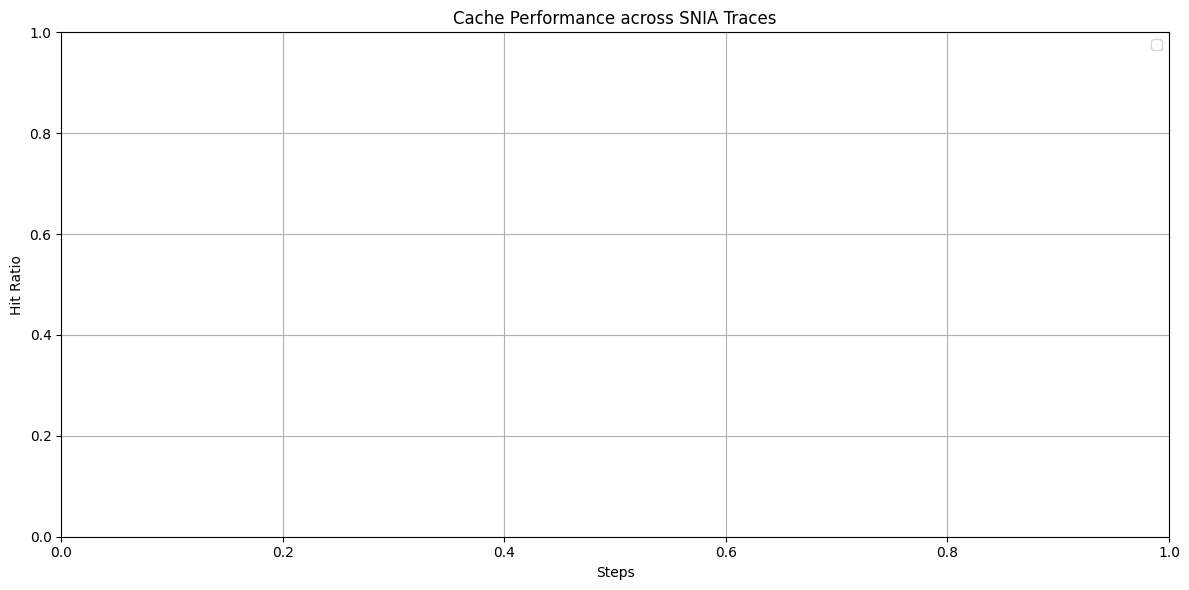

In [9]:
plt.figure(figsize=(12, 6))
log_folder = "/Users/soumyananduri/Desktop/logs"

for file in os.listdir(log_folder):
    if file.endswith(".gz"):
        with gzip.open(os.path.join(log_folder, file), 'rt') as f:
            df = pd.read_csv(f)
            plt.plot(df['step'], df['hit_ratio'], label=file.split(".")[0], linewidth=1.5)

plt.xlabel('Steps')
plt.ylabel('Hit Ratio')
plt.title("Cache Performance across SNIA Traces")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
